In [55]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,6)
from datetime import datetime
from datetime import timedelta
from functools import reduce

from darts import TimeSeries
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    Prophet,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
    RegressionEnsembleModel,
    RegressionModel,
    Theta,
    FFT
)

from darts.metrics import mape, mase
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis, plot_hist
from darts.datasets import AirPassengersDataset

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read data and build a TimeSeries

In [48]:
df = pd.read_csv("./data/wet-bulb-temperature-hourly.csv")
print(df.head())
dt = [datetime.strptime(df.iloc[n,0], "%Y-%m-%d")+timedelta(hours=int(df.iloc[n,1])-1) for n in range(df.shape[0])]
df.index = dt
df.drop(["wbt_date","wbt_time"],axis=1,inplace=True)
print(df.head())


     wbt_date  wbt_time  wet_bulb_temperature
0  1982-01-01         1                  24.7
1  1982-01-01         2                  24.5
2  1982-01-01         3                  24.3
3  1982-01-01         4                  24.2
4  1982-01-01         5                  24.2
                     wet_bulb_temperature
1982-01-01 00:00:00                  24.7
1982-01-01 01:00:00                  24.5
1982-01-01 02:00:00                  24.3
1982-01-01 03:00:00                  24.2
1982-01-01 04:00:00                  24.2


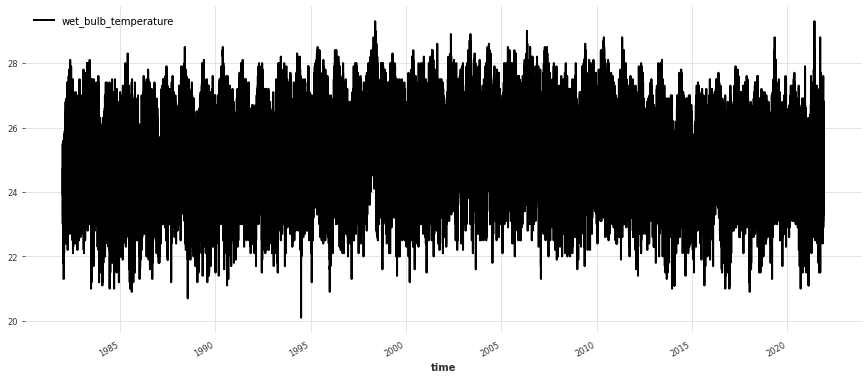

In [56]:
series = TimeSeries.from_dataframe(df)
series.plot()

## Creating a training and validation series

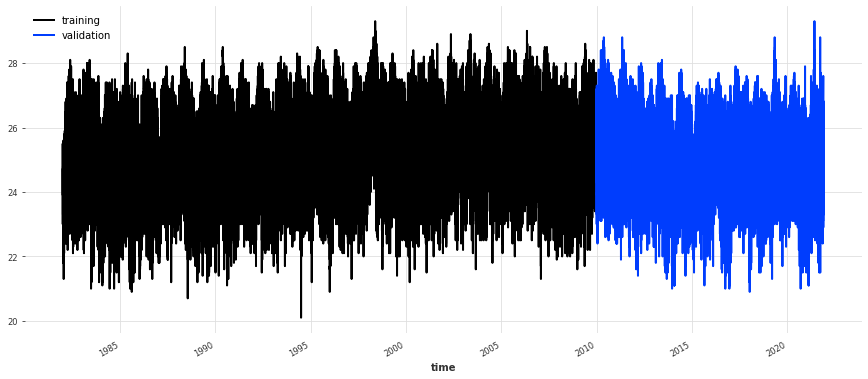

In [68]:
train, val = series.split_before(pd.Timestamp('20100101'))
tmp, _ = val.split_before(pd.Timestamp('20100103'))
train.plot(label='training')
val.plot(label='validation')
plt.legend();

## Playing with naive models

There is a collection of “naive” baseline models in darts, which can be very useful to get an idea of the bare minimum accuracy that one could expect. For example, the NaiveSeasonal(K) model always “repeats” the value that occured K time steps ago.

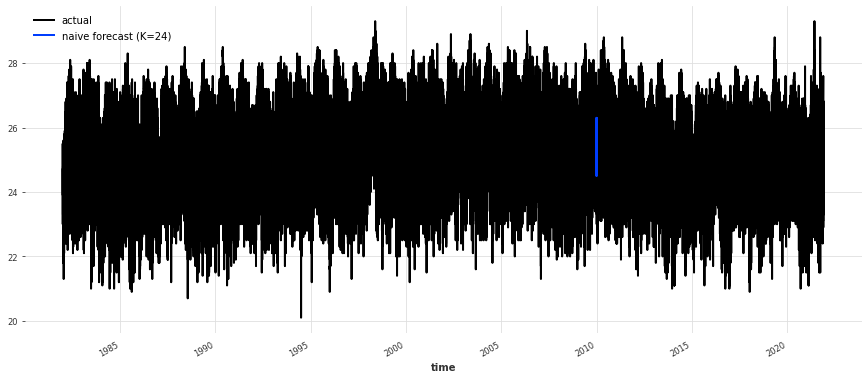

In [65]:
naive_model = NaiveSeasonal(K=24)
naive_model.fit(train)
naive_forecast = naive_model.predict(48)

series.plot(label='actual')
naive_forecast.plot(label='naive forecast (K=24)')
plt.legend();

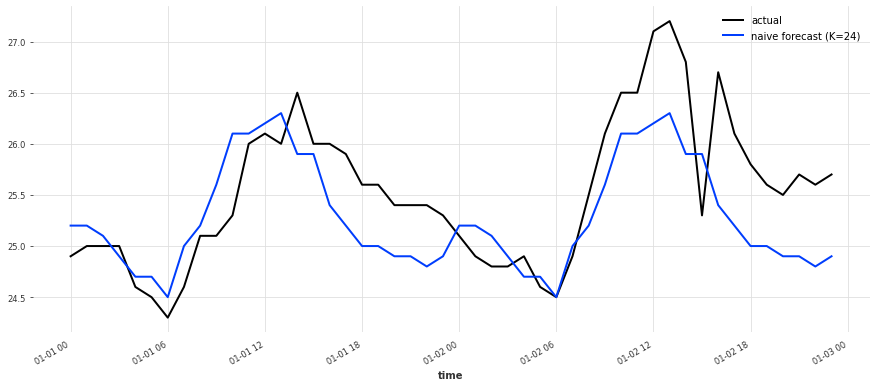

In [81]:
val[:48].plot(label='actual')
naive_forecast.plot(label='naive forecast (K=24)')
plt.legend();

## Inspect Seasonality

It seems quite obvious that the data has a daily seasonality, which we can confirm by looking at the auto-correlation function (ACF), and highlighting the lag `m=24`:

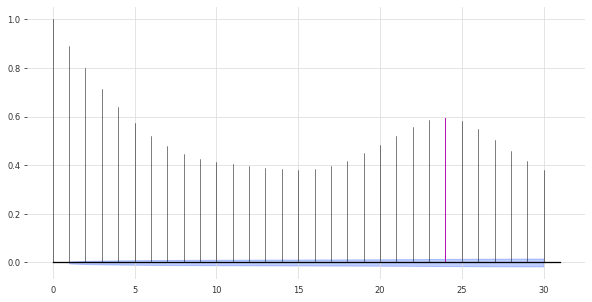

In [71]:
plot_acf(train, m=24, alpha = .05, max_lag=30)

The ACF presents a spike at x = 24, which suggests a daily seasonality trend (highlighted in red). The blue zone determines the significance of the statistics for a confidence level of alpha = 5%.

In [73]:
for m in range(2, 30):
    is_seasonal, period = check_seasonality(train, m=m, alpha=.05, max_lag=30)
    if is_seasonal:
        print('There is seasonality of order {}.'.format(period))

There is seasonality of order 24.


## A less naive model

NaiveDrift model will simply produce linear predictions, with a slope that is determined by the first and last values of the training set.

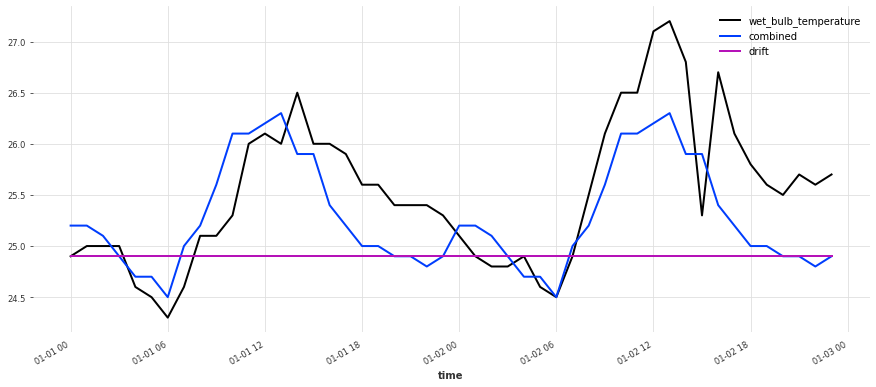

In [74]:
seasonal_model = NaiveSeasonal(K=24)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(48)

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(48)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

tmp.plot()
combined_forecast.plot(label='combined')
drift_forecast.plot(label='drift')
plt.legend();

In [75]:
print("Mean absolute percentage error for the combined naive drift + seasonal: {:.2f}%.".format(
      mape(series, combined_forecast)))

Mean absolute percentage error for the combined naive drift + seasonal: 1.73%.


## Quickly try a few more models

`darts` is built to make it easy to train and validate several models in a unified way. Let’s train a few more and compute their respective MAPE on the validation set:

In [76]:
def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print('model {} obtains MAPE: {:.2f}%'.format(model, mape(val, forecast)))

eval_model(ExponentialSmoothing())
eval_model(Prophet())
eval_model(AutoARIMA())
eval_model(Theta())

model ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=ModelMode.ADDITIVE, seasonal_periods=24 obtains MAPE: 129.80%
model Prophet obtains MAPE: 2.63%
model Auto-ARIMA obtains MAPE: 3.09%
model Theta(2) obtains MAPE: 3.01%


Here, we did only built these models with their default parameters. We can probably do better if we fine-tune to our problem. Let’s try with the Theta method.

## The Theta method

The model Theta contains an implementation of Assimakopoulos and Nikolopoulos’ Theta method. This method has known great success, particularly in the [M3-competition](https://en.wikipedia.org/wiki/Makridakis_Competitions).

Though the value of the Theta parameter is often set to 0 in applications, our implementation supports a variable value for parameter tuning purposes. Let’s try to find a good value for Theta:

In [77]:
# Search for the best theta parameter, by trying 50 different values
thetas = 2 - np.linspace(-10, 10, 50)

best_mape = float('inf')
best_theta = 0

for theta in thetas:
    model = Theta(theta)
    model.fit(train)
    pred_theta = model.predict(len(val))
    res = mape(val, pred_theta)

    if res < best_mape:
        best_mape = res
        best_theta = theta

In [78]:
best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred_best_theta = best_theta_model.predict(len(val))

print('The MAPE is: {:.2f}, with theta = {}.'.format(mape(val, pred_best_theta), best_theta))

The MAPE is: 3.01, with theta = 1.387755102040817.


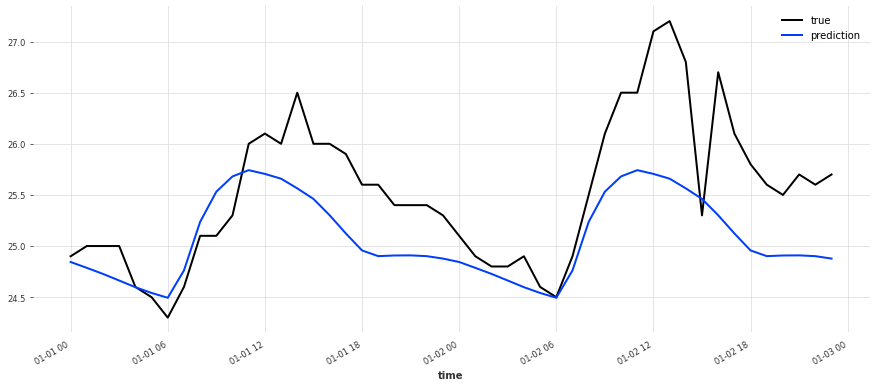

In [80]:
val[:48].plot(label='true')
pred_best_theta[:48].plot(label='prediction')
plt.legend();

## ExponentialSmoothing model

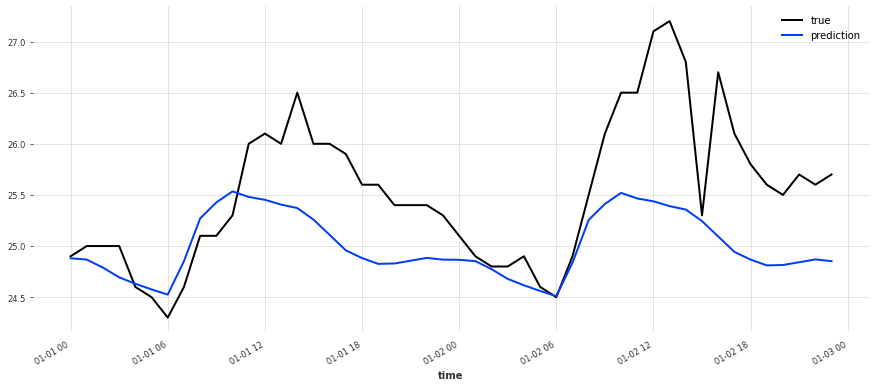

In [90]:
model_es = ExponentialSmoothing()
model_es.fit(train)
pred_es = model_es.predict(len(val))

val[:48].plot(label='true')
pred_es[:48].plot(label='prediction')
plt.legend();

In [93]:
# plot_residuals_analysis(model_es.residuals(val))

## Prophet

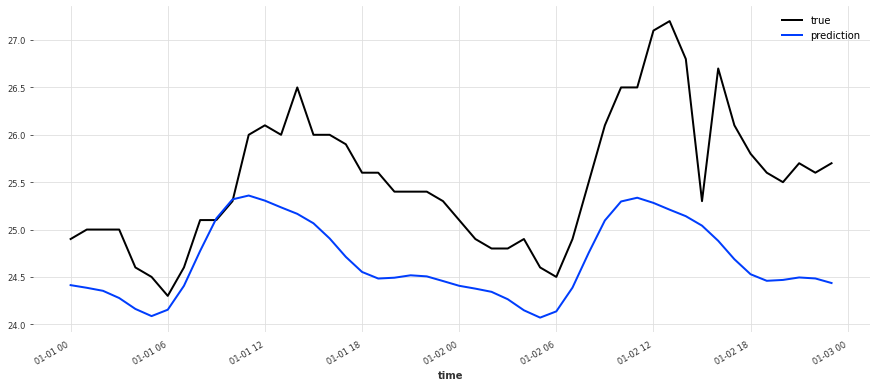

In [94]:
model_p = Prophet()
model_p.fit(train)
pred_p = model_p.predict(len(val))

val[:48].plot(label='true')
pred_p[:48].plot(label='prediction')
plt.legend();